In [2]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA
from matplotlib.collections import LineCollection
import pandas as pd

import scipy.io

In [9]:
# Load original data:

data_470 = pd.read_csv('/Users/haotianli/Documents/MATLAB/behaviorAnalysis/Data_470.csv')
data_555 = pd.read_csv('/Users/haotianli/Documents/MATLAB/behaviorAnalysis/Data_555.csv')

data_470 = data_470.to_numpy()
data_555 = data_555.to_numpy()

data_470_tensor = torch.tensor(data_470)
data_555_tensor = torch.tensor(data_555)
print(f'data_470_tensor.shape:', data_470_tensor.shape)
print(f'data_555_tensor.shape:', data_555_tensor.shape)

data_both_tensor = torch.cat((data_470_tensor, data_555_tensor), dim=1)
print(f'data_both_tensor.shape:', data_both_tensor.shape)

mvData = scipy.io.loadmat('/Users/haotianli/Documents/MATLAB/behaviorAnalysis/orginalMovements.mat') # mvData is a Dict
print(f'mvData.keys():', mvData.keys())

originalMovements = mvData['pred']
originalMovements = torch.tensor(originalMovements)
print(f'originalMovements.shape:', originalMovements.shape)


data_470_tensor.shape: torch.Size([2249, 2])
data_555_tensor.shape: torch.Size([2249, 2])
data_both_tensor.shape: torch.Size([2249, 4])
mvData.keys(): dict_keys(['__header__', '__version__', '__globals__', 'pred'])
originalMovements.shape: torch.Size([2250, 3, 21])


In [38]:
# Movements data pre-processing:

relativeMovements = torch.empty_like(originalMovements)

for i in range(20):
    relativeMovements[:, :, i] = originalMovements[:, :, i] - originalMovements[:, :, 0]

# print(relativeMovements[0, :, :])
print(f'relativeMovements.shape:', relativeMovements.shape)

# combinedMovements = torch.empty(2236, 3, 21, 15)
# for i in range(2235):
#     combinedMovements[i, :, :, :] = torch.cat([relativeMovements[i, :, :].unsqueeze(-1), relativeMovements[i+1, :, :].unsqueeze(-1), relativeMovements[i+2, :, :].unsqueeze(-1),
#                                                   relativeMovements[i+3, :, :].unsqueeze(-1), relativeMovements[i+4, :, :].unsqueeze(-1), relativeMovements[i+5, :, :].unsqueeze(-1),
#                                                   relativeMovements[i+6, :, :].unsqueeze(-1), relativeMovements[i+7, :, :].unsqueeze(-1), relativeMovements[i+8, :, :].unsqueeze(-1),
#                                                   relativeMovements[i+9, :, :].unsqueeze(-1), relativeMovements[i+10, :, :].unsqueeze(-1), relativeMovements[i+11, :, :].unsqueeze(-1),
#                                                   relativeMovements[i+12, :, :].unsqueeze(-1), relativeMovements[i+13, :, :].unsqueeze(-1), relativeMovements[i+14, :, :].unsqueeze(-1)],
#                                                  dim=-1)
# print(f'combinedMovements.shape:', combinedMovements.shape)
# print(combinedMovements[0])

recombinedMovements = torch.empty(2236, 3, 21, 4)
for i in range(2236):
    recombinedMovements[i, :, :, 0] = relativeMovements[i+7, :, :]
    recombinedMovements[i, :, :, 1] = originalMovements[i+9, :, :] - originalMovements[i+5, :, :]
    recombinedMovements[i, :, :, 2] = originalMovements[i+11, :, :] - originalMovements[i+3, :, :]
    recombinedMovements[i, :, :, 3] = originalMovements[i+14, :, :] - originalMovements[i, :, :]
    
print(f'recombinedMovements.shape:', recombinedMovements.shape)
print(recombinedMovements[0, :, 0, :])


relativeMovements.shape: torch.Size([2250, 3, 21])
recombinedMovements.shape: torch.Size([2236, 3, 21, 4])
tensor([[  0.0000, -12.9267, -15.9575, -16.8614],
        [  0.0000,  -8.8318,  -8.4177,   1.4512],
        [  0.0000,   8.6168,   7.0354,   1.4820]])


In [40]:
max_iterations = 10000
output_dimension = 32 # here, we set as a variable for hypothesis testing below.

In [41]:
cebra_dr_both_behavior = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [47]:
dataForBehavior = data_both_tensor[6:-7]

# DR for movement infomation(could be tuned):
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

finalInputData = torch.empty(2236, 3, 4)

# recombinedMovements.shape: torch.Size([2236, 3, 21, 4])
for j in range(4):
    data_matrix = recombinedMovements[:, :, :, j].reshape(2236, -1).numpy()
    pca = PCA(n_components=3)
    reduced_data = pca.fit_transform(data_matrix)
    
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(reduced_data)
    
    finalInputData[:, :, j] = torch.tensor(normalized_data)
    
finalInputData = finalInputData.reshape(2236, -1)
print(f'finalInputData.shape:', finalInputData.shape)

finalInputData.shape: torch.Size([2236, 12])


In [48]:
cebra_dr_both_behavior.fit(dataForBehavior, finalInputData)
cebra_dr_both_behavior_para = cebra_dr_both_behavior.transform(dataForBehavior)

pos: -0.4996 neg:  6.4711 total:  5.9715 temperature:  1.0000: 100%|██████████| 10000/10000 [01:37<00:00, 102.57it/s]


In [51]:
cebra_dr_both_time_behavior = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid = True)

In [52]:
cebra_dr_both_time_behavior.fit(dataForBehavior, finalInputData)
cebra_dr_both_time_behavior_para = cebra_dr_both_time_behavior.transform(dataForBehavior)

behavior_pos: -0.3736 behavior_neg:  6.4127 behavior_total:  6.0391 time_pos: -0.7448 time_neg:  6.4127 time_total:  5.6679: 100%|██████████| 10000/10000 [02:47<00:00, 59.69it/s]


In [53]:
cebra_dr_both_time_behavior_shuffle = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [54]:
### Shuffle the behavior variable and use it for training
shuffled_posdir = np.random.permutation(finalInputData)
cebra_dr_both_time_behavior_shuffle.fit(dataForBehavior, shuffled_posdir)
cebra_dr_both_time_behavior_shuffle_para = cebra_dr_both_time_behavior_shuffle.transform(dataForBehavior)

pos: -0.5665 neg:  6.7355 total:  6.1690 temperature:  1.0000: 100%|██████████| 10000/10000 [01:43<00:00, 96.77it/s]


In [55]:
cebra_dr_both_time = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.12,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [56]:
cebra_dr_both_time.fit(dataForBehavior)
cebra_dr_both_time_para = cebra_dr_both_time.transform(dataForBehavior)

pos: -0.6985 neg:  6.3693 total:  5.6708 temperature:  1.1200: 100%|██████████| 10000/10000 [01:37<00:00, 102.90it/s]


In [108]:
def plot_cebra_both(ax, embedding, label, gray = False, idx_order = (0,1,2)):
    r_ind = torch.ones(label.size(0), dtype=torch.bool)
    print(r_ind)
    l_ind = 0 # 这里假设所有点都满足r标签为真(目前的系统不需要考虑左右标签，可以降维结束后另外更改作图条件)

    if not gray:
        r_cmap = 'cool'
        l_cmap = 'viridis'
        r_c = label[r_ind, 0]
        l_c = label[l_ind, 0]
    else:
        r_cmap = None
        l_cmap = None
        r_c = 'gray'
        l_c = 'gray'

    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [r_ind,idx1], # 只启用这里的scatter,产生的是假颜色
               embedding [r_ind,idx2],
               embedding [r_ind,idx3],
               c=r_c,
               cmap=r_cmap, s=0.2)
    l=ax.scatter(embedding [l_ind,idx1],
               embedding [l_ind,idx2],
               embedding [l_ind,idx3],
               c=l_c,
               cmap=l_cmap, s=0.2)

    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    return ax

tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])


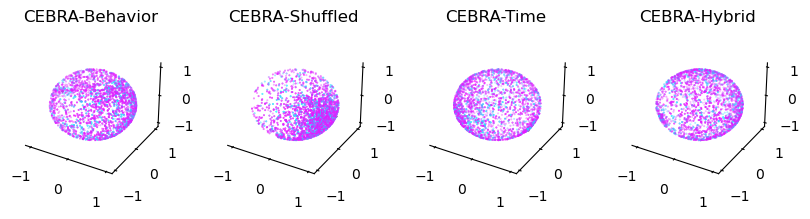

In [109]:
%matplotlib inline
fig = plt.figure(figsize=(10,2))

ax1 = plt.subplot(141, projection='3d')
ax2 = plt.subplot(142, projection='3d')
ax3 = plt.subplot(143, projection='3d')
ax4 = plt.subplot(144, projection='3d')

ax1=plot_cebra_both(ax1, cebra_dr_both_behavior_para, finalInputData)
ax2=plot_cebra_both(ax2, cebra_dr_both_time_behavior_shuffle_para, finalInputData)
ax3=plot_cebra_both(ax3, cebra_dr_both_time_para, finalInputData)
ax4=plot_cebra_both(ax4, cebra_dr_both_time_behavior_para, finalInputData)

ax1.set_title('CEBRA-Behavior')
ax2.set_title('CEBRA-Shuffled')
ax3.set_title('CEBRA-Time')
ax4.set_title('CEBRA-Hybrid')
# plt.tight_layout()
plt.show()